In [1]:
#from call_functions import *
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
import plotly.express as px
import ipywidgets as widgets

In [2]:
def func(x,w,d):
    return w**2 - x*9.81*np.tanh(x*d)

def k_from_w(w,d):
    return fsolve(func,w**2/9.81,args=(w,d))

In [3]:
g = 9.81 #(en m/s^2)
d = 1000 #(en metres)
T_p = 10 #(periode de pic)
h_s = 3  #(hauteur significative en m)

f_p = 1/T_p #(frequence de pic)
w_p = 2*np.pi*f_p #(frequence angulaire de pic)
k_p = k_from_w(w_p,d) #(nombre d'onde de pic)
l_p = np.pi*2/k_p #(longueur d'onde de pic)

L = l_p * 64 #(en metres)
Nx = (64 * 32) #//4 #(au moins 32 points par longeur d'onde de pic)
dx = L/(Nx)

xspace = np.linspace(0,L-dx,Nx)
#xspace = xspace[:-1]

#k_n = np.arange(-Nx/2,Nx/2)*2*np.pi/L

k_n = 2*np.pi*np.fft.fftfreq(Nx,dx)
w_n = np.sqrt(g*np.abs(k_n)*np.tanh(d*np.abs(k_n)))

In [4]:
# calcul de dw/dk

dw_n_dk_n = np.zeros(len(w_n))
dw_n_dk_n2 = np.zeros(len(w_n))
dw_n_dk_n[k_n!=0] = np.abs( (1/2)*(w_n[k_n!=0]/k_n[k_n!=0])*(1 + 2*k_n[k_n!=0]*d / np.sinh(2*k_n[k_n!=0]*d)))
dw_n_dk_n2[k_n!=0] = np.abs(g * (np.tanh(d*k_n[k_n!=0]) + d * k_n[k_n!=0] *(1/np.cosh(d *k_n[k_n!=0]))**2)/(2 * np.sqrt(g * k_n[k_n!=0] * np.tanh(d * k_n[k_n!=0]))))

/var/folders/vb/z01wks0d25n399v1c2rv_r6000mb9z/T/ipykernel_57233/1434424902.py:5: RuntimeWarning: overflow encountered in sinh
  dw_n_dk_n[k_n!=0] = np.abs( (1/2)*(w_n[k_n!=0]/k_n[k_n!=0])*(1 + 2*k_n[k_n!=0]*d / np.sinh(2*k_n[k_n!=0]*d)))


In [5]:
# test si dw/dk donne bien la meme chose avec les deux formulations
np.linalg.norm(dw_n_dk_n - dw_n_dk_n2)

2.916570888665544e-14

`f_p` : fréquecne de pic (de l'odre de 8 ou 10 secondes) donc `f_p = 1/8 ou 1/10`

`T_p` : période de pic donc `T_p = 8 ou 10`

In [6]:
# fonction pour calculer le spectre de jonswap (sur f)

def E(f,f_p,gamma,alpha_s):
    Ef = np.zeros(len(f))
    sigma_s = 0.07 * (f[f!=0] <= f_p) + 0.09 * (f[f!=0] > f_p)
    Ef[f!=0] = alpha_s * (9.81**2/f[f!=0]**5) * np.exp(- 5/4 * ((f_p/f[f!=0])**4)) * gamma ** np.exp(- (f[f!=0] - f_p)**2/(2*sigma_s**2*f_p**2))
    return Ef

Ef = E(w_n/(2*np.pi),w_p/(2*np.pi),3.3,1)
Ek = dw_n_dk_n * Ef * (1/(2 * np.pi))
alpha_s_new = h_s**2 /(16 * np.sum(Ek * np.abs(k_n[1] - k_n[0])))
Ek = Ek * alpha_s_new
Ef = Ef * alpha_s_new

In [7]:
np.sum(Ek * np.abs(k_n[1] - k_n[0])) - h_s**2/16

-1.1102230246251565e-16

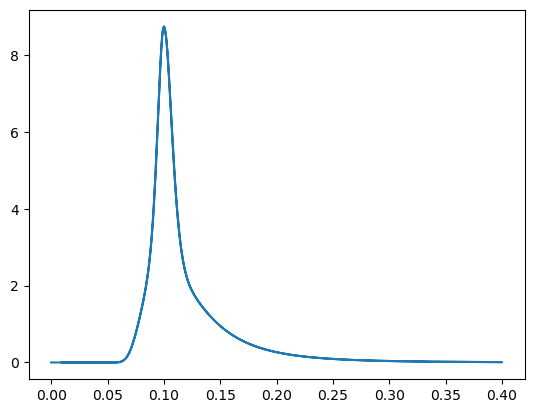

In [8]:
plt.plot(w_n/(2*np.pi),Ef)

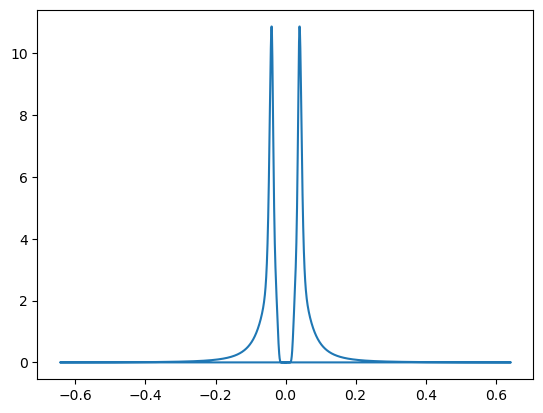

In [9]:
plt.plot(k_n,Ek)

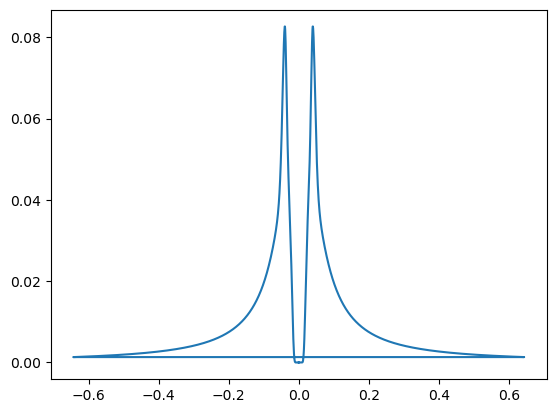

In [10]:
# EK / 2 parce que on apris deux fois le spectre (double vagues donc doubles amplitudes)

A_n = np.sqrt(2 * Ek / 2 * np.abs(k_n[1] - k_n[0]))
plt.plot(k_n,A_n)

In [11]:
t = 0
phase = np.random.rand(len(A_n)//2+1)*2*np.pi
phase = np.append(phase,np.flip(phase[(len(A_n) + 1) % 2:-1]))

A_n2 = A_n * np.exp(- 1j * (phase - w_n * t))
A_n2 = np.append(A_n2[:Nx//2].conj(),A_n2[Nx//2:])

eta = np.real(np.fft.ifft(A_n2, norm=None))*(Nx)

t = 10
A_n22 = A_n * np.exp(- 1j * (phase - w_n * t))
A_n22 = np.append(A_n22[:Nx//2].conj(),A_n22[Nx//2:])

eta2 = np.real(np.fft.ifft(A_n22, norm=None))*(Nx)

def eta_func(x,t):
    theta = np.outer(np.abs(k_n),x) - np.outer(w_n,t)
    A_n2 = A_n * np.exp(1j * (phase - w_n * t))
    return np.real(np.sum(A_n2.reshape((len(k_n),1)) * np.exp(1j * np.outer(np.abs(k_n),x)),axis=0))

def phi_func(x,t):
    theta = np.outer(np.abs(k_n),x) - np.outer(w_n,t)
    A_n2 = A_n * np.exp(1j * (phase - w_n * t))
    A_n2[w_n != 0] = A_n2[w_n != 0] * (- 1j * 9.81 / w_n[w_n != 0])
    return np.real(np.sum(A_n2.reshape((len(k_n),1)) * np.exp(1j * np.outer(np.abs(k_n),x)),axis=0))

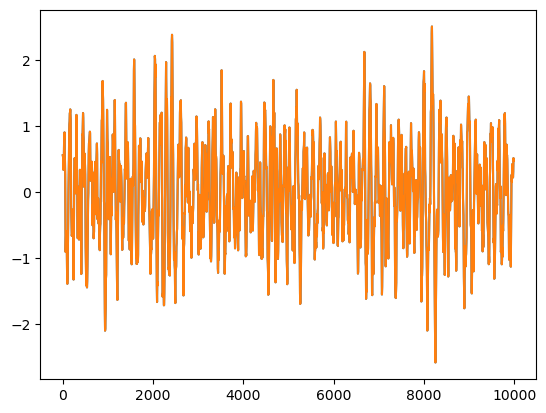

In [12]:
plt.plot(xspace,eta_func(xspace,0))
plt.plot(xspace,eta)

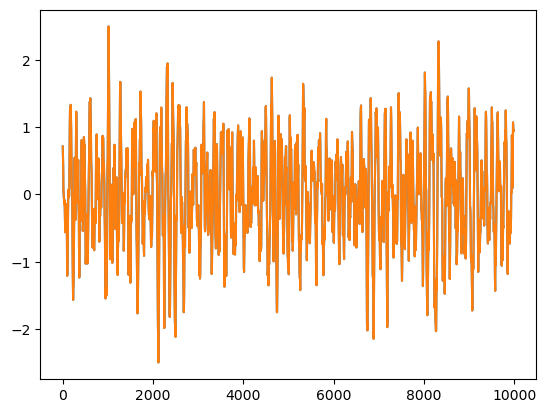

In [13]:
plt.plot(xspace,eta_func(xspace,10))
plt.plot(xspace,eta2)

In [14]:
np.linalg.norm(eta - eta_func(xspace,0))

1.5764911548169639e-12

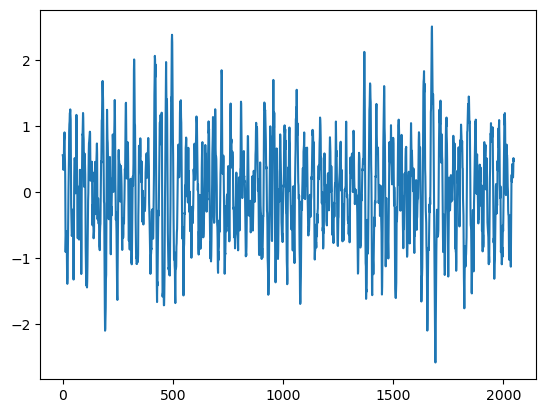

In [15]:
plt.plot(eta)

In [16]:
print(np.std(eta)**2 - h_s**2/16)

-1.725951086384292e-06


In [17]:
Lx_obs = 8*l_p*2
Nx_obs = 128*2
dx_obs = Lx_obs/(Nx_obs)
xspace_obs = np.linspace(0,Lx_obs-dx_obs,Nx_obs).reshape((Nx_obs,))

In [45]:
# Nx_obs = Nx // 8
# print(Nx_obs)
# L_obs = L
# dx_obs = L_obs/(Nx_obs)
# xspace_obs = np.linspace(0,L_obs-dx_obs,Nx_obs).reshape((Nx_obs,))

k_obs = 2*np.pi*np.fft.fftfreq(Nx_obs, dx_obs)

A_dz = np.zeros((Nx_obs, Nx_obs))
kernel = np.real(np.fft.ifft(abs(k_obs), axis=0, norm=None))*Nx_obs
for ii in range(Nx_obs):
    rolled_kernel = np.roll(kernel, ii)
    A_dz[ii, :] = 1/Nx_obs*rolled_kernel

gain = 1

I = -9.81*np.eye(Nx_obs)
O = np.zeros((Nx_obs,Nx_obs))
Obs = np.diag(xspace_obs < Lx_obs//2) * 1
A = np.block([[O, I], [A_dz, O]])
M = np.block([[O, I], [A_dz, -gain * Obs]])

In [46]:
print(k_obs.shape)
print(k_n.shape)

(256,)
(2048,)


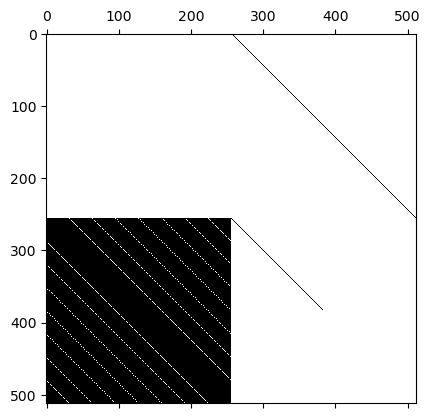

In [47]:
plt.spy(M)

In [48]:
def func_model(u,t):
    return np.dot(A,u)

def g(t):
    return np.concatenate((np.zeros(Nx_obs),np.dot(Obs,eta_func(xspace_obs,t))))

def func_obs(u,t):
    return np.dot(M,u) + gain * g(t)

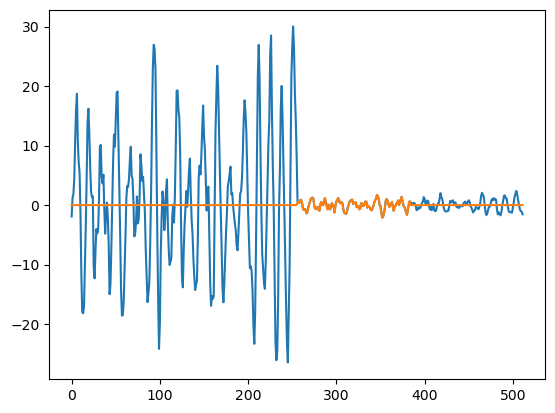

In [49]:
T = 0

plt.plot(np.concatenate((phi_func(xspace_obs,T),eta_func(xspace_obs,T))))
plt.plot(g(T))

In [50]:
y0 = np.concatenate((phi_func(xspace_obs,0),eta_func(xspace_obs,0)))
y0_obs = np.zeros(Nx_obs*2)
y0_obs = g(0)

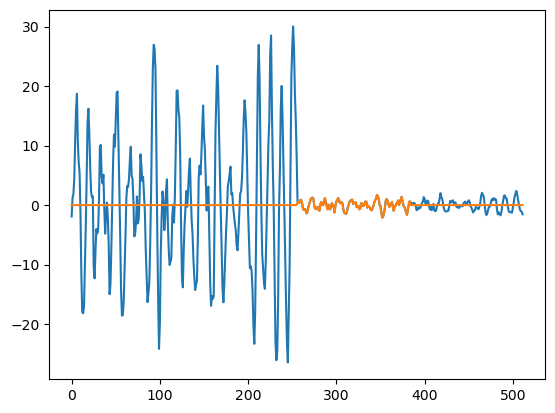

In [51]:
plt.plot(y0)
plt.plot(y0_obs)

In [52]:
Tend = 1200
tspace = np.linspace(0,Tend,Tend)

sol_obs = odeint(func_obs, y0_obs, tspace)
#sol = odeint(func_model, y0, tspace)

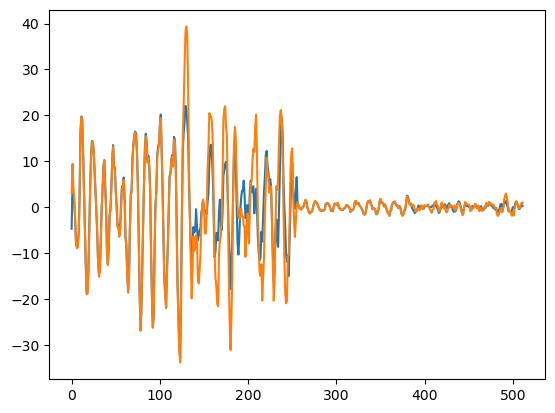

In [53]:
plt.plot(np.concatenate((phi_func(xspace_obs,Tend),eta_func(xspace_obs,Tend))))
plt.plot(sol_obs[-1,:])

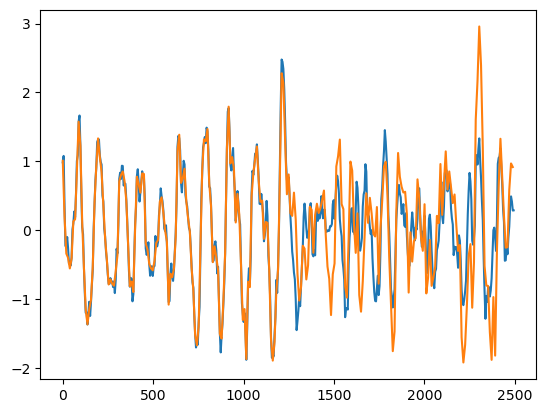

In [58]:
plt.plot(xspace[0:Nx//4],eta_func(xspace[0:Nx//4],Tend))
plt.plot(xspace_obs,sol_obs[-1,:][Nx_obs:])

In [55]:
print('SSP obs =',
    np.linalg.norm(np.fft.fft(eta_func(xspace_obs,Tend)) - np.fft.fft(sol_obs[-1,:][Nx_obs:]),2)/(np.linalg.norm(np.fft.fft(eta_func(xspace_obs,Tend)),2) + np.linalg.norm(np.fft.fft(sol_obs[-1,:][Nx_obs:]),2)))

SSP obs = 0.26218997320171006


In [29]:
print('SSP obs =',
    np.linalg.norm(np.fft.fft(eta_func(xspace_obs,Tend)) - np.fft.fft(sol_obs[-1,:][Nx_obs:]),2)/(np.linalg.norm(np.fft.fft(eta_func(xspace_obs,Tend)),2) + np.linalg.norm(np.fft.fft(sol_obs[-1,:][Nx_obs:]),2)))
print('SSP sol =',
      np.linalg.norm(np.fft.fft(eta_func(xspace_obs,Tend)) - np.fft.fft(sol[-1,:][Nx_obs:]),2)/(np.linalg.norm(np.fft.fft(eta_func(xspace_obs,Tend)),2) + np.linalg.norm(np.fft.fft(sol[-1,:][Nx_obs:]),2)))

SSP obs = 0.7105846594996079


NameError: name 'sol' is not defined

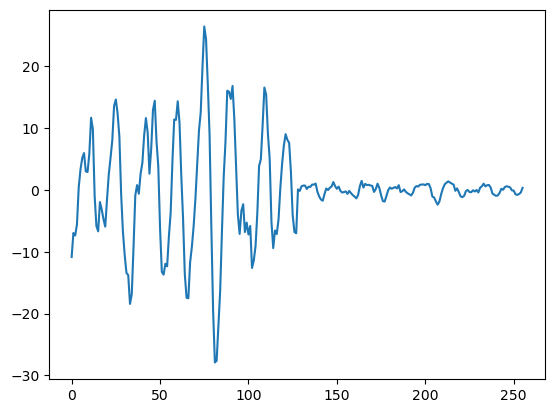

In [ ]:
plt.plot(np.concatenate((phi_func(xspace_obs,Tend),eta_func(xspace_obs,Tend))) - sol_obs[0,:])

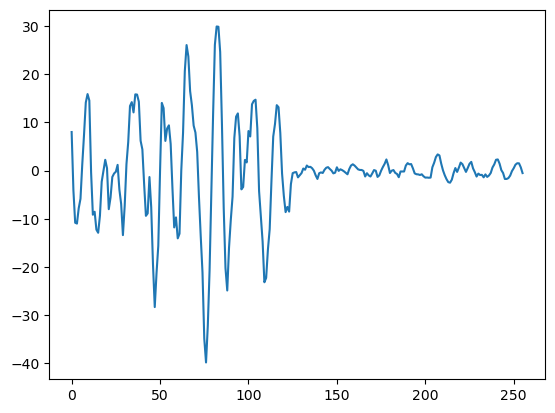

In [ ]:
plt.plot(sol_obs[-1,:] - np.concatenate((phi_func(xspace_obs,Tend),eta_func(xspace_obs,Tend))))


In [ ]:
px.line(x=xspace_obs.reshape(len(xspace_obs)),y=[sol_obs[-1,:][Nx_obs:],eta_func(xspace_obs,Tend)])

In [ ]:
px.line(x=xspace_obs.reshape(len(xspace_obs)),y=[sol[-1,:][Nx_obs:],eta_func(xspace_obs,Tend)])

In [ ]:
sol[-1,:].shape

(256,)

In [ ]:
np.linalg.norm(np.fft.fft(eta_func(xspace_obs,Tend)) - np.fft.fft(sol[-1,:][Nx_obs:]),2)/(np.linalg.norm(np.fft.fft(eta_func(xspace_obs,Tend)),2) + np.linalg.norm(np.fft.fft(sol[-1,:][Nx_obs:]),2))

0.6700911208339656